In [ ]:
# LSTM

In [ ]:
!pip install yfinance==0.2.40

import math
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


from pandas_datareader import data as wb
import yfinance as yfin
yfin.pdr_override()

import pandas.tseries.offsets as offsets
import matplotlib.pyplot as plt
import torch.optim as optim
import warnings
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
%matplotlib inline
warnings.simplefilter('ignore')
plt.style.use("ggplot")

[*********************100%%**********************]  1 of 1 completed


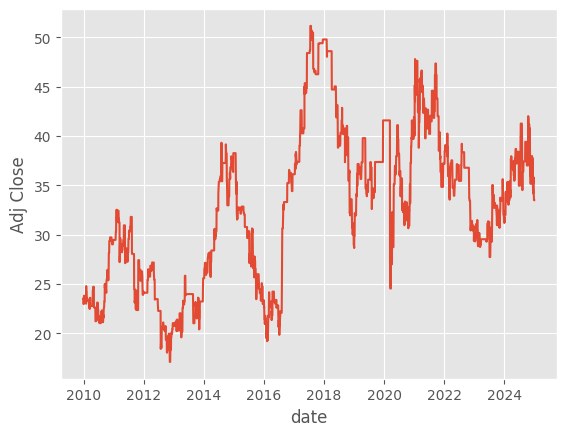

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3776 entries, 2009-12-29 to 2024-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3776 non-null   float64
 1   High       3776 non-null   float64
 2   Low        3776 non-null   float64
 3   Close      3776 non-null   float64
 4   Adj Close  3776 non-null   float64
 5   Volume     3776 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 206.5 KB


In [ ]:
# Parameter for data
## Security code
stock_code='BRTHY'
## Start Date
start_date='2003-1-1'
## End Date
end_date='2024-12-31'
## Split ratio of train data and validation data
train_rate=0.7
## How many business days to see
observation_period_num=60
## How many business days to predict
predict_period_num=5

# Parameter for mdoel
## Learning Rate
lr=0.00005
## Epoch Number
epochs=1000
## Mini-Batch size
batch_size=64
## How many epochs to stop train if valid loss is not decreasing
patience=20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get data
df=wb.DataReader(stock_code,start=start_date,end=end_date)

# Plot 'Adj Close' values
plt.plot(df.iloc[:,-2])
plt.xlabel('date')
plt.ylabel('Adj Close')
plt.show()

df.info()


In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-29,23.500000,23.500000,23.500000,23.500000,23.500000,500
2009-12-30,23.500000,23.500000,23.500000,23.500000,23.500000,0
2009-12-31,22.950001,22.950001,22.950001,22.950001,22.950001,500
2010-01-04,22.950001,22.950001,22.950001,22.950001,22.950001,0
2010-01-05,23.790001,23.790001,23.790001,23.790001,23.790001,1000


In [ ]:
# Normalization
mean_list=df.mean().values
std_list=df.std().values
df=(df-mean_list)/std_list
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-29,-1.174437,-1.175965,-1.172729,-1.174343,-1.174343,0.180763
2009-12-30,-1.174437,-1.175965,-1.172729,-1.174343,-1.174343,-0.214787
2009-12-31,-1.244534,-1.246010,-1.242854,-1.244410,-1.244410,0.180763
2010-01-04,-1.244534,-1.246010,-1.242854,-1.244410,-1.244410,-0.214787
2010-01-05,-1.137477,-1.139032,-1.135755,-1.137398,-1.137398,0.576312
...,...,...,...,...,...,...
2024-12-23,0.182903,0.180366,0.185132,0.182407,0.182407,0.022543
2024-12-24,0.182903,0.180366,0.185132,0.182407,0.182407,-0.214787
2024-12-26,-0.021017,0.095038,-0.018866,0.097053,0.097053,0.259873


In [ ]:
# Array initialization
inout_data=[]

# Put data in array
for i in range(len(df)-observation_period_num-predict_period_num):
  data=df.iloc[i:i+observation_period_num,4].values
  label=df.iloc[i+predict_period_num:i+observation_period_num+predict_period_num,4].values
  inout_data.append((data,label))
inout_data=torch.FloatTensor(inout_data)

train_data=inout_data[:int(np.shape(inout_data)[0]*train_rate)].to(device)
valid_data=inout_data[int(np.shape(inout_data)[0]*train_rate):].to(device)

print('train data：',np.shape(train_data)[0])
print('valid data：',np.shape(valid_data)[0])

train data： 2597
valid data： 1114


In [ ]:
print(train_data)

tensor([[[-1.1743, -1.1743, -1.2444,  ..., -1.1642, -1.1642, -1.2699],
         [-1.1374, -1.1374, -1.1374,  ..., -1.2699, -1.2699, -1.2699]],

        [[-1.1743, -1.2444, -1.2444,  ..., -1.1642, -1.2699, -1.2699],
         [-1.1374, -1.1374, -1.1374,  ..., -1.2699, -1.2699, -1.2699]],

        [[-1.2444, -1.2444, -1.1374,  ..., -1.2699, -1.2699, -1.2699],
         [-1.1374, -1.1374, -1.1374,  ..., -1.2699, -1.2699, -1.2699]],

        ...,

        [[-0.5093, -0.5093, -0.5093,  ...,  0.4741,  0.4741,  0.4741],
         [ 0.3034,  0.3034,  0.3034,  ...,  0.1467,  0.2665,  0.2665]],

        [[-0.5093, -0.5093, -0.5093,  ...,  0.4741,  0.4741,  0.4741],
         [ 0.3034,  0.3034,  0.3034,  ...,  0.2665,  0.2665,  0.2780]],

        [[-0.5093, -0.5093,  0.3034,  ...,  0.4741,  0.4741,  0.4741],
         [ 0.3034,  0.3034,  0.3034,  ...,  0.2665,  0.2780,  0.2780]]])


In [ ]:
# モデル定義
class LSTM(nn.Module):
    def __init__(self, hidden_size=100):
        super().__init__()
        self.hidden_size = hidden_size
        # input_sizeは入力する次元数
        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size) # batch_first=True
        self.linear = nn.Linear(self.hidden_size, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x_last = x[-1]
        x = self.linear(x_last)

        return x

In [ ]:
# Define a function for getting mini-batch
def get_batch(source, i, batch_size):
  seq_len=min(batch_size, len(source)-1-i)
  data=source[i:i+seq_len]
  input=torch.stack(torch.stack([item[0] for item in data]).chunk(observation_period_num,1))
  target=torch.stack(torch.stack([item[1] for item in data]).chunk(observation_period_num,1))

  return input, target

In [ ]:
# Function for early stop of train if valid loss is not decreasing
class EarlyStopping:
    def __init__(self,patience=5):
        self.patience=patience
        self.counter=0
        self.best_score=None
        self.early_stop=False
        self.val_loss_min=np.Inf

    def __call__(self,val_loss,model):
        score=(-val_loss)
        if self.best_score is None:
            self.best_score=score
        elif score<self.best_score:
            self.counter+=1
            if self.counter>=self.patience:
                self.early_stop=True
        else:
            self.best_score=score
            self.counter=0

In [ ]:
model = LSTM(100)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

 10:epoch | 0.00434174 : train loss | 0.2452884 : valid loss
 20:epoch | 0.003819736 : train loss | 0.2122978 : valid loss
 30:epoch | 0.002998213 : train loss | 0.1546833 : valid loss
 40:epoch | 0.002448866 : train loss | 0.1325071 : valid loss
 50:epoch | 0.002180503 : train loss | 0.1215531 : valid loss
 60:epoch | 0.002103178 : train loss | 0.1259572 : valid loss
 70:epoch | 0.002075708 : train loss | 0.1223568 : valid loss
 80:epoch | 0.00205517 : train loss | 0.1191358 : valid loss
 90:epoch | 0.002045193 : train loss | 0.1196683 : valid loss
100:epoch | 0.002040477 : train loss | 0.1196165 : valid loss


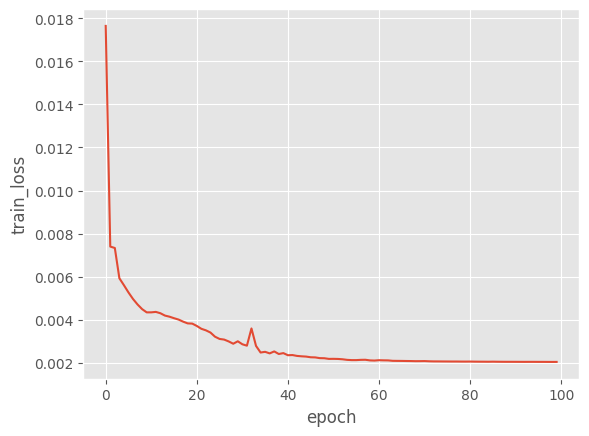

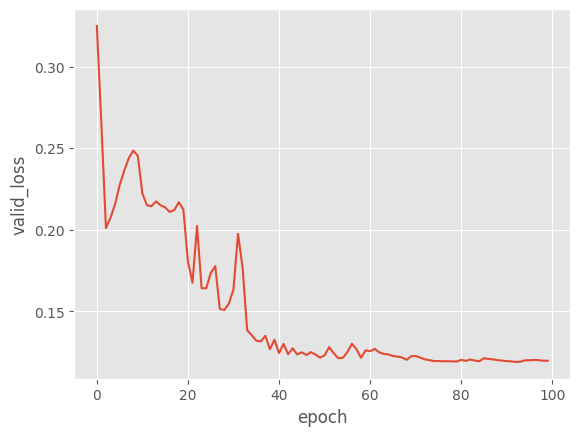

In [ ]:
# ハイパーパラメータ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 5
hidden_size = 20
output_size = 1
lr = 0.001
batch_size = 32
epochs = 100

# モデルと関連オブジェクト
model = LSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
earlystopping = EarlyStopping(patience=40)

# 損失記録用
train_loss_list = []
valid_loss_list = []


# トレーニングループ
for epoch in range(1, epochs + 1):
    # train
    model.train()
    total_loss_train = 0.0
    for batch, i in enumerate(range(0, len(train_data), batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        total_loss_train += loss.item()
    scheduler.step()
    total_loss_train = total_loss_train / len(train_data)

    # valid
    model.eval()
    total_loss_valid = 0.0
    with torch.no_grad():
        for i in range(0, len(valid_data), batch_size):
            data, targets = get_batch(valid_data, i, batch_size)
            output = model(data)
            total_loss_valid += len(data) * criterion(output, targets).cpu().item()
    total_loss_valid = total_loss_valid / len(valid_data)

    # etc
    train_loss_list.append(total_loss_train)
    valid_loss_list.append(total_loss_valid)
    if epoch % 10 == 0:
        print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
    earlystopping(total_loss_valid, model)
    if earlystopping.early_stop:
        print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
        print("Early Stop")
        break

# 損失のプロット
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.plot(train_loss_list)
plt.show()

plt.xlabel('epoch')
plt.ylabel('valid_loss')
plt.plot(valid_loss_list)
plt.show()

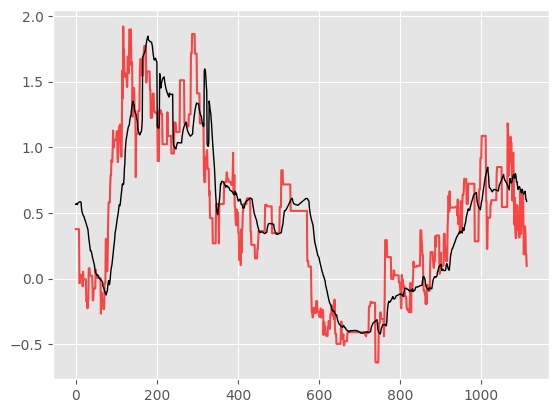

In [ ]:
model.eval()
result=torch.Tensor(0)
actual=torch.Tensor(0)

with torch.no_grad():
  for i in range(0,len(valid_data)-1):
    data,target=get_batch(valid_data,i,1)
    output=model(data)
    result=torch.cat((result, output[-1].view(-1).cpu()),0)
    actual=torch.cat((actual,target[-1].view(-1).cpu()),0)

plt.plot(actual,color='red',alpha=0.7)
plt.plot(result,color='black',linewidth=1.0)
plt.show()

In [ ]:
# MAEの計算
mae = torch.mean(torch.abs(result - actual)).item()
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 0.22969810664653778


ValueError: LSTM: Expected input to be 2D or 3D, got 1D instead